# Multiphase Systems

Kawin supports the usage of multiple phases. Nucleation and growth rate are handled for each precipitate phase independently. Coupling comes from the mass balance where all precipitates contribute to the overall mass changes in the system.

In the Al-Mg-Si system, several phases can form including: $ \beta' $, $ \beta" $, B', U1 and U2. To model precipitation of these phases, they must be defined in the .tdb file, the Thermodynamics module and the PrecipitateModel module.

When defining the thermodynamics module, the first phase in the list of phases will be the parent phase.

In [1]:
from kawin.Thermodynamics import MulticomponentThermodynamics

phases = ['FCC_A1', 'MGSI_B_P', 'MG5SI6_B_DP', 'B_PRIME_L', 'U1_PHASE', 'U2_PHASE']
therm = MulticomponentThermodynamics('AlMgSi.tdb', ['AL', 'MG', 'SI'], phases, drivingForceMethod='approximate')

In defining the precipitate model, all precipitate phases must be included. Since we already have our list of phases, we can use that and remove the parent phase.

In [2]:
from kawin.KWNEuler import PrecipitateModel

model = PrecipitateModel(0, 25*3600, 1e4, phases=phases[1:], elements=['MG', 'SI'], linearTimeSpacing=True)

## Model inputs

Setting up parameters for the parent phase and overall system is the same as for single phase systems. Here, it is just the composition (Al-0.72Mg-0.57Si in mol. %), molar volume ($1e$-$5\text{ }m^3/mol$).

The temperature will be divided into two stages: a 16 hour temper at $175\text{ }^oC$, followed by a 1 hour ramp up to $250 ^oC$. To do this, there needs to be three time designations: $175\text{ }^oC$ at 0 hours, $175\text{ }^oC$ at 16 hours and $250\text{ }^oC$ at 17 hours. The temperature can be plotted to show the profile over time. Here, a parameter called timeUnits is passed to convert the time from seconds to either minutes or hours.

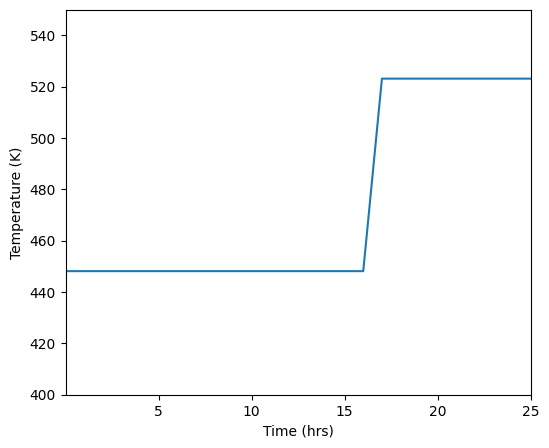

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

model.setInitialComposition([0.0072, 0.0057])
model.setVmAlpha(1e-5, 4)

lowTemp = 175+273.15
highTemp = 250+273.15
model.setTemperatureArray([0, 16, 17], [lowTemp, lowTemp, highTemp])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
model.plot(ax, 'Temperature', timeUnits='h')
ax.set_ylim([400, 550])
ax.set_xscale('linear')

Setting parameters for each precipitate phase is similar to single phase systems except that the phase has to be defined when inputting parameters.

In [4]:
gamma = {
    'MGSI_B_P': 0.18,
    'MG5SI6_B_DP': 0.084,
    'B_PRIME_L': 0.18,
    'U1_PHASE': 0.18,
    'U2_PHASE': 0.18
        }

for i in range(len(phases)-1):
    model.setInterfacialEnergy(gamma[phases[i+1]], phase=phases[i+1])
    model.setVmBeta(1e-5, 4, phase=phases[i+1])
    model.setThermodynamics(therm, phase=phases[i+1])

## Solving the model

As with single precipitate phase systems, running the model is exactly the same.

In [5]:
model.solve(verbose=True, vIt=5000)

Nucleation density not set.
Setting nucleation density assuming grain size of 100 um and dislocation density of 5e+12 #/m2


c:\Users\nury\AppData\Local\Programs\Python\Python310\lib\site-packages\pycalphad\core\utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]


N	Time (s)	Temperature (K)	MG	SI	
5000	4.5e+04		448		0.3118	0.1024	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	MGSI_B_P	2.050e+22		0.0595		1.7575e-09	8.6466e+03
	MG5SI6_B_DP	1.279e+24		0.8200		1.0870e-09	1.5759e+03
	B_PRIME_L	1.172e+16		0.0000		1.5682e-09	4.1972e+03
	U1_PHASE	3.080e+08		0.0000		3.8188e-10	4.3610e+03
	U2_PHASE	1.222e+09		0.0000		4.7452e-10	4.0113e+03

N	Time (s)	Temperature (K)	MG	SI	
10000	8.6e+04		523		0.0571	0.2035	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	MGSI_B_P	5.299e+21		1.0321		7.3370e-09	4.9014e+02
	MG5SI6_B_DP	0.000e+00		0.0000		0.0000e+00	-4.7837e+03
	B_PRIME_L	0.000e+00		0.0000		0.0000e+00	-2.5215e+03
	U1_PHASE	0.000e+00		0.0000		0.0000e+00	1.1839e+03
	U2_PHASE	0.000e+00		0.0000		0.0000e+00	-8.9218e+02

Finished in 288.454 seconds.


## Plotting

Plotting is also the same as with single phase systems. The major difference is each phase will be plotted for the radius, volume fraction, precipitate density, nucleation rate and particle size distribution. In addition, the total amount of some variables, such as the precipitate density and volume fraction, can be plotted.

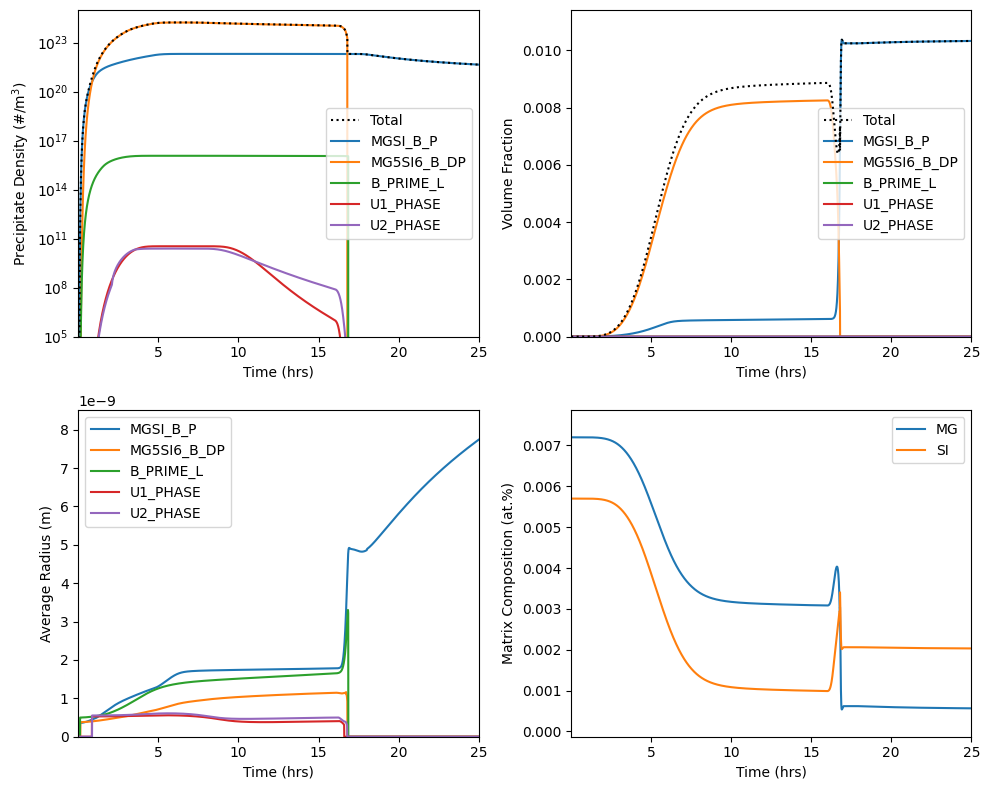

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

model.plot(axes[0,0], 'Total Precipitate Density', timeUnits='h', label='Total', color='k', linestyle=':', zorder=6)
model.plot(axes[0,0], 'Precipitate Density', timeUnits='h')
axes[0,0].set_ylim([1e5, 1e25])
axes[0,0].set_xscale('linear')
axes[0,0].set_yscale('log')

model.plot(axes[0,1], 'Total Volume Fraction', timeUnits='h', label='Total', color='k', linestyle=':', zorder=6)
model.plot(axes[0,1], 'Volume Fraction', timeUnits='h')
axes[0,1].set_xscale('linear')

model.plot(axes[1,0], 'Average Radius', timeUnits='h')
axes[1,0].set_xscale('linear')

model.plot(axes[1,1], 'Composition', timeUnits='h')
axes[1,1].set_xscale('linear')

fig.tight_layout()

## References

1. E. Povoden-Karadeniz et al, "Calphad modeling of metastable phases in the Al-Mg-Si system" *Calphad* 43 (2013) p. 94
2. Q. Du et al, "Modeling over-ageing in Al-Mg-Si alloys by a multi-phase Calphad-coupled Kampmann-Wagner Numerical model" *Acta Materialia* 122 (2017) p. 178